# Born Effective Charge Calculation

In [1]:
from pybec import analysis as bec, parsers, output, utils, plotters
#%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pykrige.uk3d import UniversalKriging3D
from sklearn import linear_model
from scipy.interpolate import Rbf
from scipy.interpolate import LinearNDInterpolator as LND

## 0. Background
To actually calculate the BECs, we remember that the Born effective charge is defined as a derivative: <br><br>
$$Z^*_{ij} = -e\frac{\partial F_i}{\partial E_j}$$ <br> Where $i$ and $j$ are directions.  Here, we care about the force in the z-direction induced by an electric field in the $z$-direction, so $i = j$, and we can focus only on the $z$-component of force.  To approximate the Born Effective Charge linearly, we subtract the $z$-component of the force before the field is applied from the $z$-component of the force on the ions in a clamped-ion calculation and divide by the magnitude of the field (0.001 au). <br><br>
$$\frac{F_{z, field} - F_{z, no field}}{E}$$ 

## 1. Point to Your Files Here

In [95]:
# # store graph images here
fig_path = '/path/to/images'

# Matrix Only Files
matrix_no_efield = '/path/to/matrix/no/electric/field/output'
matrix_clamped_ion = '/path/to/matrix/clamped/ion/output'
matrix_xyz = '/path/to/matrix/xyz'

# Nanocomposite Files
no_efield = '/path/to/nanocomposite/no/electric/field/output'
clamped_ion = '/path/to/nanocomposite/no/electric/field/output'
xyz = '/path/to/nanocomposite/xyz'

# structure files for VESTA
xsf_input = '/path/to/nanocomposite/xsf/file'
xsf_output = '/path/to/output/xsf/with/BEC/heatmap'

# nanoparticle and matrix names
no_np_name = 'no'  # dummy name that helps fill in default plot titles
np_name = '$NP NAME$'  # name of your nanoparticle inclusion
np_element='Xx'  # Ex: Ag
matrix_name = 'XYZ'  # Ex: MgO

## 2. Plot the Born Effective Charge Distribution Relative to the NP centroid

### a.) Configure Plot Settings

In [4]:
kwargs = {
    'e_field' : 0.001,
    'e_field_direction' : [0,0,1],    # [0,0,1] is the z-direction
    'cmap' : 'jet',    # jet, gist_rainbow_r 'viridis', 'plasma', 'inferno', 'magma', 'cividis', None
    'cbar_pos' : 'right',   # 'top', 'right', 'bottom'
    'legend' : True,
    'figsize' : (10, 5),
    'centroid_of' : np_element,
    'marker_dict' : {'O': 'o', 'Ag': 'x', 'Au': 'x', 'Co': 'x', 'Cu': 'x', 'Ni': 'x', 'Mg': '^', 'Si': '^'},
    'color_dict' : {'O': 'r', 'Ag': 'k', 'Au': 'k', 'Co': 'k', 'Cu': 'k', 'Ni': 'k', 'Mg': 'y','Si': 'y'},
    'grid' : True,
    'alpha' : 1.0,
    'cbar_shrink' : 1.0,
    'to_plot' : 'r'  # r, phi, or theta.  phi is the angle from the z-axis and theta is the angle in xy-plane
}

### b.) Save $Z_{zz}$ to a CSV File

In [10]:
ions = bec.gen_BEC_df(no_efield, clamped_ion, xyz, kwargs['e_field'], kwargs['e_field_direction'])
# ions.to_csv('ion_becs.csv', sep=',', index=False)

### c.) Plot It

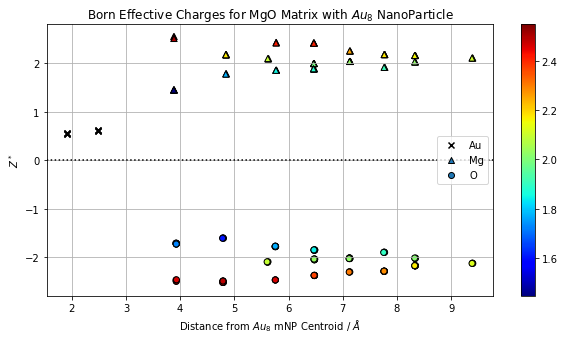

In [11]:
fig, ax, cb, pad = plotters.plot_BEC_v_spher(no_efield, clamped_ion, xyz, matrix_name, np_name, np_element, **kwargs)
#fig.tight_layout(pad=pad)
plt.show()
#fig.savefig(os.path.join(fig_path, f'BEC_v_{kwargs["to_plot"]}.png'), bbox_inches='tight')

## 2. Interpolate the Born Effective Charges and Calculate the Dipole Model

### a.) Configure based on your system

In [13]:
# nanoparticle type:
nanoparticle = 'Ag'

# whether to include the nanoparticle atoms in the interpolation/prediction of BECs
include_nanoparticle = False

# number of points per side to interpolate
res = 50

# Define the categories you want to interpolate. The ycategory is the value we are interpolating
# and the x-category is the feature used to predict the interpolated values in a linear regression
# d_field_z is the z component of the field of a point dipole located at the centroid of the
# nanoparticle
xcategory = 'd_field_z'
ycategory = 'BEC'  # 'BEC', 'BEC_enhancement'

### b.) Load the data, compute the dipole field at each ion position

In [16]:
# load the ions from their files
ions = bec.gen_BEC_df(no_efield, clamped_ion, xyz, kwargs['e_field'], kwargs['e_field_direction'])


#matrix = bh.gen_BEC_df(matrix_no_efield, matrix_clamped_ion, matrix_xyz, e_field=0.001, e_field_direction=2)

if not include_nanoparticle:
    ions_no_ag = ions[ions['element'] != nanoparticle].reset_index()
    if ycategory == 'BEC_enhancement':
        matrix_no_ag = matrix.drop(bec.find_np_atoms(matrix, ions[ions['element']==nanoparticle])).reset_index()
        ions_no_ag['BEC_enhancement'] = np.abs(ions_no_ag['BEC'].values) - np.abs(matrix_no_ag['BEC'].values)
elif ycategory == 'BEC_enhancement':
    raise ValueError("Cannot have ycategory be BEC_enhancement if including nanoparticle since there is no "
                    "reference \nvalue for nanoparticle BECs")

# Ag centroid
centroid = bec.get_centroid({nanoparticle: ions[ions['element'] == nanoparticle][['X', 'Y', 'Z']].values})

# remove np
if not include_nanoparticle:
    ions_np = ions[ions['element'] == nanoparticle].reset_index()
    ions = ions_no_ag

lattice = parsers.get_lattice(xyz)

# use an expanded cell for the interpolation (not for the regression yet)
expanded_cell = bec.pad_cell(ions, lattice, pad=0.2)

# unit vector in direction of the dipole (collinear with applied field.)
p_vec = np.array([0,0,1])

# compute the dipole field for a point dipole centered at the nanoparticle centroid
# r_vec -- vector from centroid to ion
r_vec = ions[['X','Y','Z']].values - centroid
r_mag = np.linalg.norm(r_vec, axis=1).reshape(-1,1)
r_unit = r_vec / r_mag
dipole_field = 1/r_mag**3*(np.dot(r_unit,  3*p_vec.T).reshape(-1, 1) * r_unit - p_vec)
overall_field = np.array([0,0,.001]) + dipole_field
ions['d_field_z'] = dipole_field[:,2]
ions['d_field_mag'] = np.linalg.norm(dipole_field, axis=1)


# get the limits of the lattice along the slice direction
x_lat = lattice[:, 0]
y_lat = lattice[:, 1]
z_lat = lattice[:, 2]
# for plotting xlim and ylim
min_x, max_x = min(x_lat), max(x_lat)
min_y, max_y = min(y_lat), max(y_lat)
min_z, max_z = min(z_lat), max(z_lat)

# points for interpolation
x = expanded_cell['X'].values
y = expanded_cell['Y'].values
z = expanded_cell['Z'].values
points = np.array(list(zip(x, y, z)))

if ycategory == 'BEC':
    values = np.abs(expanded_cell[ycategory].values)
else:
    values = expanded_cell[ycategory].values

# grid on which to evaluate interpolators
R = np.mgrid[min_x:max_x:res*1j, min_y:max_y:res*1j, min_z:max_z:res*1j]
grid_x, grid_y, grid_z = R[0], R[1], R[2]

### c.) Do the linear regression according to the point dipole model

In [18]:
# create training data for a linear regression
# x_train = ions_no_silver[xcategory].values.reshape(-1,1)
if ycategory == 'BEC':
    y_train = np.abs(ions[ycategory].values)
else:
    y_train = ions[ycategory].values
x_train = ions[xcategory].values.reshape(-1,1)

# define the regression models
reg = linear_model.LinearRegression()
reg_cubic = linear_model.LinearRegression()

# fit a linear regression
reg.fit(x_train, y_train)

# get the coefficients and scores for each regression
m, b = reg.coef_, reg.intercept_
R2_lin = reg.score(x_train, y_train)

# the predicted values over the interpolation grid
dfzg = bec.dipole_field(R, p_vec, centroid)[2]
dp = m*dfzg + b

### d.) Interpolate the raw BEC data using a variety of methods

In [22]:
# Universal 3D kriging
uk3d = UniversalKriging3D(x, y, z, values, variogram_model='spherical', nlags=10, enable_plotting=False, 
                          drift_terms=['regional_linear'], verbose=False)
krig_interp = bec.grid_krig_execute(uk3d.execute)  
ki = bec.apply_kriging_chunks(krig_interp, grid_x, grid_y, grid_z, (5, res, res))

In [24]:
# Radial Basis Function Interpolation
rbfi = Rbf(x, y, z, values)
ri = bec.apply_chunks(rbfi, grid_x, grid_y, grid_z)

In [25]:
# Linear Interpolation
lndi = LND(points, values)
li = lndi(grid_x, grid_y, grid_z)

### e.) Plot all of the interpolated data to determine the preferred interpolation method

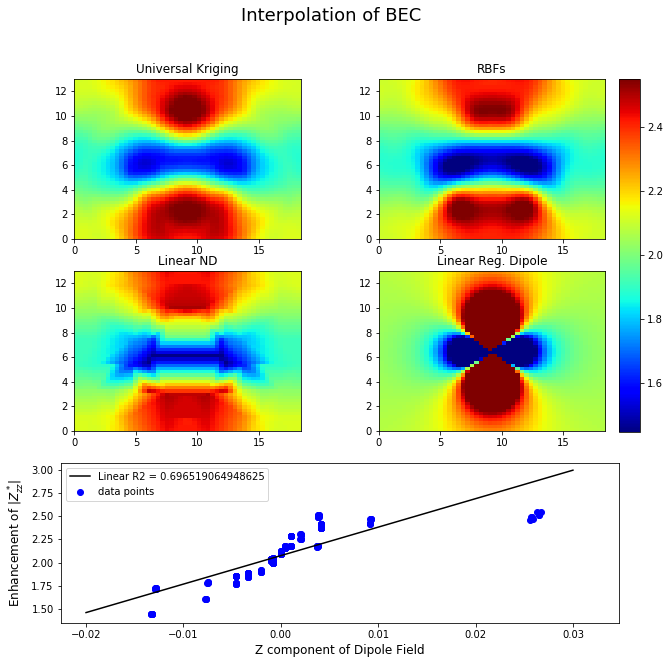

In [27]:
cmap = 'jet'  # viridis, civiridis, plasma, magma, gist_rainbow_r

# change slice num to cycle through the 3D data (can go from 0 to res)
%matplotlib inline

s = res-1    # slice number
extent = np.sqrt((max_x-min_x)**2 + (max_y-min_y)**2)    # The axis limits for the plot
cut = (grid_x + grid_y > grid_y[1, s, 1] - 0.001) & (grid_x + grid_y < grid_y[1, s, 1] + 0.001)    # (110) plane

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(3,2,1)
ax1.set_title('Universal Kriging')
plot1 = ax1.imshow(ki[cut].reshape(s+1,res).T, origin='lower', extent=(0,extent,0,max_z), cmap=cmap,
                  vmin=np.min(y_train), vmax=np.max(y_train)) 

ax2 = fig.add_subplot(3,2,2)
ax2.set_title('RBFs')
plot2 = ax2.imshow(ri[cut].reshape(s+1,res).T, origin='lower', extent=(0,extent,0,max_z), cmap=cmap,
                  vmin=np.min(y_train), vmax=np.max(y_train))

ax3 = fig.add_subplot(3,2,3)
ax3.set_title('Linear ND')
plot3 = ax3.imshow(li[cut].reshape(s+1,res).T, origin='lower', extent=(0,extent,0,max_z), cmap=cmap,
                  vmin=np.min(y_train), vmax=np.max(y_train))

ax7 = fig.add_subplot(3,2,4)
ax7.set_title('Linear Reg. Dipole')
plot7 = ax7.imshow(dp[cut].reshape(s+1,res).T, origin='lower', extent=(0,extent,0,max_z), cmap=cmap,
                   vmin=np.min(y_train), vmax=np.max(y_train))

# show the regression curves
x_line = np.linspace(-.02, 0.03, 50)
y_line = m*x_line + b
#y2 = m1*x_line + m2*x_line**2 + m3*x_line**3 + b3
ax9 = fig.add_subplot(3,1,3)
ax9.scatter(x_train, y_train, c='b', label='data points')
ax9.plot(x_line, y_line, label='Linear R2 = {}'.format(R2_lin), c='k')
#ax9.plot(x_line, y2, 'k--', label='Cubic R2 = {}'.format(R2_cub))
ax9.set_xlabel('Z component of Dipole Field', fontsize=12)
if ycategory == 'BEC_enhancement':
    lab = 'Enhancement of $\left| Z^*_{zz}\\right |$'
elif ycategory == 'BEC':
    lab = '$\left| Z^*_{zz}\\right |$'
else:
    lab = ycategory
ax9.set_ylabel('Enhancement of $\left| Z^*_{zz}\\right |$', fontsize=12)
ax9.legend()
plt.suptitle("Interpolation of {}".format(ycategory), fontsize=18)
#plt.tight_layout(pad=2)

# add colorbar
cbaxes = fig.add_axes([0.9, 0.39, 0.03, 0.49])
cb = fig.colorbar(plot3, cax = cbaxes, orientation='vertical', shrink=1)

fig.savefig(os.path.join(fig_path, 'Interpolated_BEC.svg'), bbox_inches='tight')

## 3.) Save the Desired Volumetric Data to XCrysden Format for Use in VESTA

In [28]:
# if input and output are the same, it will append the volumetric data directly
# otherwise, it will copy the input file first and then append
datagrid_name = 'Interpolated_BECs'
data = dp    # ki = kriging, ri = rbf, li = linear, dp = dipole model 

In [29]:
output.add_datagrid_3d(xsf_input, xsf_output, data, lattice, name=datagrid_name)